In [67]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.random as rng
from scipy.special import expit as sigmoid
from math import log2
#from sklearn.neural_network import BernoulliRBM

def load_mnist_digit(digit, dataset_size):
    assert(digit >= 0 and digit < 10)
    with open("datasets/{}.npy".format(digit),'rb') as f:
        return np.load(f)[:dataset_size]
    
def flatten_dataset(images):
    smushed = images.copy()
    return smushed.reshape((smushed.shape[0], -1))

dataset_size = 20  # that's how many of EACH digit there is. Can go as high as... what, 5000?
current_digits = flatten_dataset(load_mnist_digit(0,dataset_size))
for i in range(1,3):
    current_digits = np.vstack((current_digits, flatten_dataset(load_mnist_digit(i,dataset_size))))

In [68]:
print (current_digits.shape)
num_pats = current_digits.shape[0]
num_visibles = current_digits.shape[1]

(60, 784)


## Show some examples....

(60, 784)


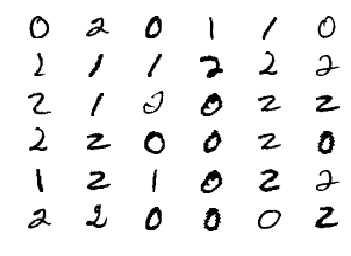

In [69]:
print(current_digits.shape)
i=0
for r in range(6):
    for c in range(6):
        plt.subplot(6,6,i+1)
        plt.imshow(current_digits[rng.randint(num_pats)].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        i += 1

### Start from random initial weights and bias weights

In [70]:
v = current_digits
num_hiddens = 100
h = np.zeros(shape=(num_pats, num_hiddens), dtype=int)
W = rng.normal(0,1,size=(num_hiddens, num_visibles))
hidden_biases = rng.normal(size=(1, num_hiddens))
visible_biases = rng.normal(size=(1, num_visibles))
change = 0

### Do some learning, using CD1 (contrastive divergence)

In [ ]:
num_iterations = 250
announce_every = num_iterations / 10
learning_rate, momentum = 0.005, 0.95

for t in range(num_iterations):
    # push visible pats into hidden 
    h_prob1 = sigmoid(np.dot(v, W.T) + hidden_biases)
    h_first = 1*(h_prob1 > rng.random(size=h_prob1.shape))
    
    # push hidden pats into visible 
    v_prob1 = sigmoid(np.dot(h_first, W) + visible_biases)
    v_reconstruction = v_prob1  # = 1*(v_prob1 > rng.random(size=v_prob1.shape))

    # push visible pats into hidden 
    h_prob1 = sigmoid(np.dot(v_reconstruction, W.T) + hidden_biases)
    h_second = 1*(h_prob1 > rng.random(size=h_prob1.shape))

    Hebb = ((np.array([h_first]*num_visibles).T)  * (np.array([v]*num_hiddens))).sum(1)
    AntiHebb = ((np.array([h_second]*num_visibles).T)  * (np.array([v_reconstruction]*num_hiddens))).sum(1)

    change = learning_rate * (Hebb - AntiHebb) + momentum * change
    W += change
    if (t % announce_every == 0): 
        print (t)

print(h.shape, v.shape)

0
25
50
75
100
125
150
175
200
225

## dreams
Will they ever make sense?

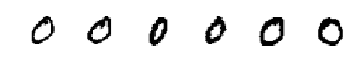

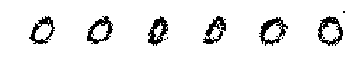

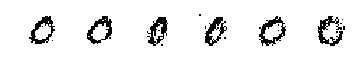

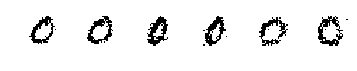

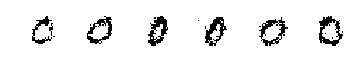

In [88]:
num_examples = 6
V_test = current_digits[0:num_examples,:]
i = 0
num_Gibbs = 0
for s in range(5):
    for t in range(num_Gibbs):
        # push visible pats into hidden 
        h_prob1 = sigmoid(np.dot(V_test, W.T) + hidden_biases)
        h = 1*(h_prob1 > rng.random(size=h_prob1.shape))
        # push hidden pats into visible 
        v_prob1 = sigmoid(np.dot(h, W) + visible_biases)
        V_test = v_prob1  # OR....  1*(v_prob1 > rng.random(size=v_prob1.shape))
    for n in range(num_examples):
        i += 1
        plt.subplot(5,num_examples,i)
        plt.imshow(V_test[n].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
    num_Gibbs = max(1, num_Gibbs * 10)  # wait longer before showing the next sample...
    plt.show()

So, we see them falling away from their initial state into the land of dreams as the model loses track of where it started from.

## features

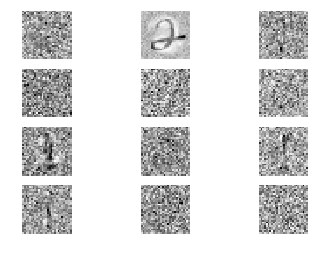

In [83]:
i=0
for r in range(4):
    for c in range(3):
        plt.subplot(4,3,i+1)
        plt.imshow(W[i].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        i += 1